In [ ]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pprint import pprint
import keras
import sklearn
import tensorflow as tf
tf.__version__

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Import the data

In [3]:
def load_dico(path,key_int=False,print_me=False):
    with open(path) as f:
        dico_str = json.loads(json.load(f))

    if key_int:
        conv_key=lambda k:int(k)
    else:
        conv_key=lambda k:k

    dico={conv_key(k):v for k,v in dico_str.items()}

    if print_me:
        print(dico)

    return dico

In [4]:
class classCLASS:

    def __init__(self,id,name,behaviors,sampling_weight=1,loss_weight=1):
        self.id=id
        self.name=name
        self.behaviors=behaviors
        self.sampling_weight=sampling_weight
        self.loss_weight=loss_weight

In [5]:
""" a dictionary to store all the information """
memo=pd.Series()

In [6]:
#Path to the folder containing the Hawksbill dataset downloaded from Zenodo
Folder_data="~/Hawksbill"


In [7]:
#Split the data into training/validation/testing dataset based on the individuals
NAMES_TRAIN=memo["NAMES_TRAIN"]=[
    'CC-09-80_08-03-2023_1',
    'CC-09-80_08-03-2023_2',
    'CC-09-72_02-11-2022_1',
    'CC-09-80_16-05-2023_1',
    'CC-09-80_16-05-2023_2']

NAMES_VAL=memo["NAMES_VAL"]=[
    'CC-09-72_01-02-2023_1',
    'CC-09-72_01-02-2023_2',
    ]


NAMES_TEST=memo["NAMES_TEST"]=[
    'CC-09-80_28-03-2023_1',
    'CC-09-80_28-03-2023_2',

    'CC-09-80_01-02-2023_1']

NAMES_ALL=NAMES_TRAIN+NAMES_VAL+NAMES_TEST


In [8]:
dico_info_A=load_dico(Folder_data+"/dico_info.json",print_me=True);

{'Freq': 20, 'col_names': ['Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]', 'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]', 'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Magnetometer X [µT]', 'Magnetometer Y [µT]', 'Magnetometer Z [µT]', 'Depth [m]', 'Light intensity 1 [raw]', 'Temperature (depth) [°C]', 'Pressure_corr', 'Pressure_diff', 'beh']}


In [9]:
# Parameters

Other=classCLASS(0,"Other",None,1,1)
Breathing=classCLASS(1,"Breathing",[1,2,46,47],1,1)
Feeding=classCLASS(2,"Feeding",[3,4,5,6,7,8,12,13,14,15,20,21,22,23,24,26,29,30,33],1,2)
Gliding=classCLASS(3,"Gliding",[18,19],1,1)
Resting=classCLASS(4,"Resting",[35,36,37,38],1,1)
Scratching=classCLASS(5,"Scratching",[40,41,42],1,2)
Swimming=classCLASS(6,"Swimming",[0,9,10,11,17,34,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,66,67,69],1,2)
CLASSES=[Other,Breathing,Feeding,Gliding,Resting,Scratching,Swimming]

DESCRIPTORS_SELEC=[0,1,2,3,4,5,13]
FREQ=20
WINDOW_DURA=40 #size of the window in seconds
WINDOW_SIZE=int(WINDOW_DURA*FREQ) #size of the window and therefore input
BEH_COL=14

#Case that we want to explore based on the associated article Jeantet et al. 
#Case3_exp1 : fine-tune all the layer
#Case3_exp2 : fine-tune the decoder, freeze the encoder
#Case3_exp3 : fine-tune the encoder, freeze the decoder
#Case3_exp4: fine-tune only the softmax layer
CASE=memo["Case"]="Case3_exp1" 


In [10]:
#Check the columns we selected

DESC_NAMES=dico_info_A['col_names']
DESC_NAMES_SELEC=[]
for i,name in enumerate(DESC_NAMES):
    if i in DESCRIPTORS_SELEC:
        prefix=""
        DESC_NAMES_SELEC.append(name)
    else:
        prefix="-----suppressed----->"
    print(prefix,i,name)


 0 Accelerometer X [m/s²]
 1 Accelerometer Y [m/s²]
 2 Accelerometer Z [m/s²]
 3 Gyroscope X [mrad/s]
 4 Gyroscope Y [mrad/s]
 5 Gyroscope Z [mrad/s]
-----suppressed-----> 6 Magnetometer X [µT]
-----suppressed-----> 7 Magnetometer Y [µT]
-----suppressed-----> 8 Magnetometer Z [µT]
-----suppressed-----> 9 Depth [m]
-----suppressed-----> 10 Light intensity 1 [raw]
-----suppressed-----> 11 Temperature (depth) [°C]
-----suppressed-----> 12 Pressure_corr
 13 Pressure_diff
-----suppressed-----> 14 beh


In [11]:
#save everyhting in dictionary

for CLASS in CLASSES:
    memo["CLASSES_"+CLASS.name]=CLASS.__dict__

memo["DESCRIPTORS_SELEC"]=DESCRIPTORS_SELEC
memo["WINDOW_DURA"]=WINDOW_DURA
memo['FREQ']=FREQ




## Load matrices



In [12]:
Matrices={}
Labels={}

for name in NAMES_ALL:
        print(name)
        full_name=Folder_data+"/"+name+".npy"
        if not os.path.exists(full_name):
            assert 1==0,"the file:"+full_name+" doesn't exist"
        else:
            full_mat=np.load(full_name)
            pre_label= full_mat[:,BEH_COL]

            label=np.zeros_like(pre_label)
            for CLASS in CLASSES:
                if CLASS!=Other:
                    for beh in CLASS.behaviors:
                        label[pre_label==beh]=CLASS.id

            mat=full_mat[:,DESCRIPTORS_SELEC]
            print("loading the matrice:"+name)
            print("shape:",mat.shape)
            print("Time in seconds:",len(mat)/FREQ)
            print("Time in hours:",round(len(mat)/FREQ/60/60,2))
            print("              ")
            Matrices[name]=mat
            Labels[name]=label



CC-09-80_08-03-2023_1
loading the matrice:CC-09-80_08-03-2023_1
shape: (531000, 7)
Time in seconds: 26550.0
Time in hours: 7.38
              
CC-09-80_08-03-2023_2
loading the matrice:CC-09-80_08-03-2023_2
shape: (420299, 7)
Time in seconds: 21014.95
Time in hours: 5.84
              
CC-09-72_02-11-2022_1
loading the matrice:CC-09-72_02-11-2022_1
shape: (685601, 7)
Time in seconds: 34280.05
Time in hours: 9.52
              
CC-09-80_16-05-2023_1
loading the matrice:CC-09-80_16-05-2023_1
shape: (480267, 7)
Time in seconds: 24013.35
Time in hours: 6.67
              
CC-09-80_16-05-2023_2
loading the matrice:CC-09-80_16-05-2023_2
shape: (232536, 7)
Time in seconds: 11626.8
Time in hours: 3.23
              
CC-09-72_01-02-2023_1
loading the matrice:CC-09-72_01-02-2023_1
shape: (615327, 7)
Time in seconds: 30766.35
Time in hours: 8.55
              
CC-09-72_01-02-2023_2
loading the matrice:CC-09-72_01-02-2023_2
shape: (663280, 7)
Time in seconds: 33164.0
Time in hours: 9.21
          

### Normalize

In [13]:
nb_col=Matrices[NAMES_ALL[0]].shape[1]
for matrix in Matrices.values():
        for j in range(nb_col):
            matrix[:,j]-=matrix[:,j].mean()
            matrix[:,j]/=matrix[:,j].std()

# Create Folder with the date of today to save the prediction

In [14]:
import datetime
now = datetime.datetime.now()
today=now.strftime("%Y_%m_%d")
today

'2024_06_02'

In [ ]:
#Path of the folder where to save the model and predictions
Folder_out="~/Out_model/"+ CASE + "/model="+today

import shutil
if os.path.exists(Folder_out):
    #shutil.rmtree(DIR_OUT)
    print("the directory already created:",Folder_out)
else:
    print("we create the directory:",Folder_out)
    os.makedirs(Folder_out)


# Data Generator

In [16]:
def density_for_one_promotion(turtle_name, CLASS):

    label=Labels[turtle_name]

    N = len(label)
    dens = np.zeros_like(label)

    dens[label==CLASS.id] = 1

    sum_dens=np.sum(dens)
    if  sum_dens<1e-6:
        print("the class to promote:"+CLASS.name +" is not present in:"+turtle_name)
        dens[:]=1
        sum_dens=len(dens)


    dens/=sum_dens

    # creating a mask.
    kernel = np.ones(int(1.5*WINDOW_SIZE))
    kernel/=np.sum(kernel)
    #gauss = np.exp(-t**2)
    #gauss /= np.sum(gauss)

    # convolving label with a mask
    dens_conv = np.convolve(dens, kernel, mode='same')

    dens_conv[-WINDOW_SIZE//2-2:]=0
    dens_conv[:WINDOW_SIZE//2+2]=0

    cdf=np.cumsum(dens_conv)
    cdf/=cdf[-1]

    def rand_gene():
        while True:
                yield np.argmax(cdf>np.random.random())-WINDOW_SIZE//2

    return dens,dens_conv,cdf,rand_gene()

In [17]:
class InterestingTurtles:

    def __init__(self,turtle_names,CLASS):
        self.turtle_names=turtle_names
        self.occurences=np.zeros(len(turtle_names))
        self.CLASS=CLASS

        for i,name in enumerate(turtle_names):
            self.occurences[i]+=np.sum(Labels[name]==CLASS.id)

        self.proba=self.occurences/np.sum(self.occurences)

    def give_me_one_turtle(self):
        return np.random.choice(a=self.turtle_names,p=self.proba)

### Global generator
(See Jeantet et al. 2021 for details)\
The global generator draws a data window among the specified individuals (turtle_names), favoring a window that contains behaviors with a higher class.sampling_weight index. 10% of the windows are randomly selected without taking into account the sampling_weight index. 
In detail:  

* We draw a behavior (theClass) based on CLASS.sampling_weight
* We select a turtle (theTurtle) based on InterestingTurtles function which going to give a individual who express this behavior (higher probability if the individual express this behavior more than the other one)
* We draw a time window using the density_for_one_promotion generator associated with the turtle and the behavior.

In [18]:
class Global_generator:

    def __init__(self,turtle_names):

        self.turtle_names=turtle_names

        self.interesting_turtles_by_class={}

        self.proba_of_classes=np.zeros(len(CLASSES))

        for CLASS in CLASSES:
            self.interesting_turtles_by_class[CLASS.name]=InterestingTurtles(turtle_names,CLASS)
            self.proba_of_classes[CLASS.id]=CLASS.sampling_weight

        self.proba_of_classes/=np.sum(self.proba_of_classes)


        print([ (CLASS.name,self.proba_of_classes[CLASS.id]) for CLASS in CLASSES])


        self.class_2_index_gene={}

        for CLASS in CLASSES:

            random_index_generators={}
            for name in turtle_names:
                _,_,_,gene=density_for_one_promotion(name,CLASS)
                random_index_generators[name]=gene

            self.class_2_index_gene[CLASS.name]=random_index_generators



    def give_me_turtle_and_timeIndex(self):

        if np.random.rand()<0.1:
            theTurtle=np.random.choice(self.turtle_names)
            deb=0
            fin=len(Labels[theTurtle])-WINDOW_SIZE
            t=np.random.randint(deb,fin)
            return theTurtle,t

        theClass=np.random.choice(CLASSES,p=self.proba_of_classes)
        theTurtle=self.interesting_turtles_by_class[theClass.name].give_me_one_turtle()


        theGenerators=self.class_2_index_gene[theClass.name]
        theGenerator=theGenerators[theTurtle]
        return theTurtle,next(theGenerator)

In [19]:
def oneEpoch_generator_window(turtle_names, size=100):


    generator=Global_generator(turtle_names)

    while True:

        X = np.empty([size,WINDOW_SIZE,len(DESCRIPTORS_SELEC)])
        Y = np.empty([size,WINDOW_SIZE],dtype=int)

        for i in range(size):
            turtle_name,t=generator.give_me_turtle_and_timeIndex()
            matrix=Matrices[turtle_name]
            label=Labels[turtle_name]
            X[i,:,:]=matrix[t:t+WINDOW_SIZE ,:]
            Y[i,:]=label[t:t+WINDOW_SIZE]

        yield X, keras.utils.to_categorical(Y,len(CLASSES))


##### Histogram of the behavior distribution with global generator (for 2000 windows)

In [20]:
global_generator=Global_generator(NAMES_TRAIN)

[('Other', 0.14285714285714285), ('Breathing', 0.14285714285714285), ('Feeding', 0.14285714285714285), ('Gliding', 0.14285714285714285), ('Resting', 0.14285714285714285), ('Scratching', 0.14285714285714285), ('Swimming', 0.14285714285714285)]
the class to promote:Other is not present in:CC-09-80_08-03-2023_1
the class to promote:Resting is not present in:CC-09-80_08-03-2023_2
the class to promote:Resting is not present in:CC-09-80_16-05-2023_2
the class to promote:Scratching is not present in:CC-09-80_16-05-2023_2


In [21]:
res=[]
for i in range(2000):
    theTurtle,t=global_generator.give_me_turtle_and_timeIndex()
    window=Labels[theTurtle][t:t+WINDOW_SIZE]
    res.extend(window)

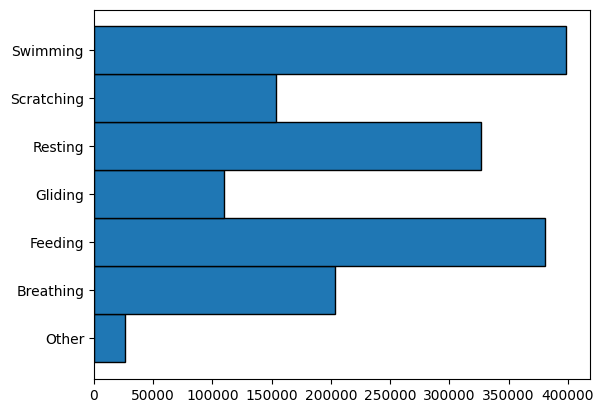

In [22]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(res,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=[CLASS.name for CLASS in CLASSES]
plt.yticks(xtics,xtics_label);


# Pre-trained V-net 

## Load the model

In [23]:
#Path where the pre-trained model is saved
Folder_model="Model_weights/Green_turtle"
LR_initial=memo["Lr_initial"]=0.0001
BATCH_SIZE=memo["batch_size"]=32

In [24]:

def load_model(folder):

    # load json and create model
    json_file = open(folder+"/model.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(folder+"/model.h5")
    return loaded_model


In [ ]:
model=load_model(Folder_model)


In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 800, 7)]             0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 800, 32)              1152      ['input_2[0][0]']             
                                                                                                  
 conv1d_20 (Conv1D)          (None, 800, 32)              5120      ['conv1d_19[0][0]']           
                                                                                                  
 batch_normalization_7 (Bat  (None, 800, 32)              128       ['conv1d_20[0][0]']           
 chNormalization)                                                                           

### Dice and Loss function

In [27]:
def dice_coef_perCat(y_true, y_pred,smooth=1e-8):
    intersection = tf.reduce_sum(y_true * y_pred,axis=[0])
    dice=(2. * intersection + smooth) / (tf.reduce_sum(y_true,axis=[0]) + tf.reduce_sum(y_pred,axis=[0]) + smooth)
    "at the end, we average the categories"
    return dice

In [28]:
ponde=np.array([CLASS.loss_weight for CLASS in CLASSES],dtype=np.float32)
print(ponde)
ponde/=np.sum(ponde)
ponde

[1. 1. 2. 1. 1. 2. 2.]


array([0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.2], dtype=float32)

In [29]:
def dice_loss(y_true, y_pred):
    smooth=1e-8

    "we average the dice by category"
    return 1-tf.reduce_mean(dice_coef_perCat(y_true, y_pred,smooth)*ponde)

## Freeze or fine-tune the layers

In [30]:


  ####According to the case selected, select layers to fine-tune
if CASE=="Case3_exp1":
     '''fine-tune all the layers'''
     for k in range(47):
      model.layers[k].trainable = True  
  
elif CASE=="Case3_exp2":
    '''encoder frozen / decoder fine tuned'''
    for k in range(22):
      model.layers[k].trainable = False
    for k in range(22,47):
      model.layers[k].trainable = True

elif CASE=="Case3_exp3":
    '''encoder fine tuned / decoder frozen'''
    for k in range(22):
      model.layers[k].trainable = True
    for k in range(22,47):
      model.layers[k].trainable = False

elif CASE=="Case3_exp4":
    '''only softmax fine-tuned'''
    for k in range(47):
      model.layers[k].trainable = False
    model.layers[46].trainable= True

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 800, 7)]             0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 800, 32)              1152      ['input_2[0][0]']             
                                                                                                  
 conv1d_20 (Conv1D)          (None, 800, 32)              5120      ['conv1d_19[0][0]']           
                                                                                                  
 batch_normalization_7 (Bat  (None, 800, 32)              128       ['conv1d_20[0][0]']           
 chNormalization)                                                                           

## Compile the model

In [32]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_initial),loss=dice_loss,metrics=["accuracy"])
memo["function_loss"]="dice_loss"

# Training

In [33]:
import time

class Trainer():

    def __init__(self,model):

        self.model_name=Folder_out+"/model.json"
        self.weights_name=Folder_out+"/model.h5"
        self.monitor="val_loss"

        # model
        self.model = model

        # training info
        self.history = None
        self.Nb_epochs = 10
        self.best_epoch = 0
        self.durations = []
        self.total_duration = 0
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history = []
        self.val_acc_history = []
        #self.nb_models = 8

        # evaluation info
        self.score = None
        self.y_true = None
        self.y_pred = None


        self.best_epoch = 0
        self.best_value = 1e10
        self.best_epochs=[]
        self.best_values=[]

        self.epoch_count=-1



    def train(self, nb_additional_epochs, batch_size,train_gene, val_gene, learning_rate=None ,patience=1e10):

        if learning_rate is not None:
          tf.set_value(self.model.optimizer.lr, learning_rate)

        # early stopping initialization
        counter = 0

        # training epoch
        try:
            for k in range(nb_additional_epochs):

                self.epoch_count+=1


                if counter >= patience:
                    print("The model is not improving any more. Stopping the training process..")
                    break


                starting_time = time.time()

                # data generation
                print("new data generation")
                X_ep, Y_ep = next(train_gene)
                X_val_ep, Y_val_ep = next(val_gene)

                self.history = self.model.fit(
                    X_ep,
                    Y_ep,
                    batch_size=batch_size,
                    initial_epoch=self.epoch_count,
                    epochs=self.epoch_count+1,
                    validation_data=(X_val_ep,Y_val_ep)
                )


                # saving training epoch history
                duration=time.time()-starting_time
                self.durations.append(duration)
                self.total_duration+=duration

                self.loss_history.append(self.history.history["loss"][0])
                self.val_loss_history.append(self.history.history["val_loss"][0])
                self.acc_history.append(self.history.history["accuracy"][0])
                self.val_acc_history.append(self.history.history["val_accuracy"][0])

                current_value = self.history.history[self.monitor][0]


                if current_value < self.best_value:
                    print(self.monitor +  " improved from {:.5f} to {:.5f}".format(self.best_value, current_value))
                    self.best_value = current_value
                    self.best_epoch = self.epoch_count
                    self._save_model()
                    print("Model is saved on epoch {:d}.".format(self.best_epoch))
                    counter = 0
                    self.best_epochs.append(self.best_epoch)
                    self.best_values.append(self.best_value)

                else:
                    print(self.monitor + " did not improve.")
                    counter += 1


        except KeyboardInterrupt:
            print("\n Interuption volontaire")



    def _save_model(self):

        # serialize model to JSON
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
              json_file.write(model_json)

        # serialize weights to HDF5
        self.model.save_weights(self.weights_name)



    def plot_training(self):

        print(self.monitor,":",self.best_epoch,self.best_value)
        print(self.best_epochs,self.best_values)



        fig,ax = plt.subplots(2,1 , figsize=(16, 10), sharex=True)

        # loss
        a=np.arange(len(self.loss_history))
        ax[0].plot(a,self.loss_history,label="loss")
        ax[0].plot(a,self.val_loss_history,label="val_loss")
        ax[0].legend()
        ax[0].set_title("Loss per epoch", color='coral', fontsize=16)

        if self.monitor == "val_loss":
            ax[0].plot(self.best_epochs,self.best_values,'o',label="best_loss")


        # accuracy
        ax[1].plot(a,self.acc_history,label="accuracy")
        ax[1].plot(a,self.val_acc_history,label="val_accuracy")
        ax[1].legend()
        ax[1].set_title("Accuracy per epoch", color='coral', fontsize=16)
        if self.monitor == "val_accuracy":
            ax[1].plot(self.best_epochs,self.best_values,'o',label="best_acc")

        ax[1].set_xlabel("epoch")

        fig.savefig(Folder_out+"/loss_acc_per_epoch.png")

In [34]:
memo["nb_train_per_epoch"]=6000
train_gen=oneEpoch_generator_window(NAMES_TRAIN,size = memo["nb_train_per_epoch"])

X,Y=next(train_gen)
X.shape,Y.shape

[('Other', 0.14285714285714285), ('Breathing', 0.14285714285714285), ('Feeding', 0.14285714285714285), ('Gliding', 0.14285714285714285), ('Resting', 0.14285714285714285), ('Scratching', 0.14285714285714285), ('Swimming', 0.14285714285714285)]
the class to promote:Other is not present in:CC-09-80_08-03-2023_1
the class to promote:Resting is not present in:CC-09-80_08-03-2023_2
the class to promote:Resting is not present in:CC-09-80_16-05-2023_2
the class to promote:Scratching is not present in:CC-09-80_16-05-2023_2


((6000, 800, 7), (6000, 800, 7))

In [35]:
memo["nb_val_per_epoch"]=3000
valid_gen=oneEpoch_generator_window(NAMES_VAL,size = memo["nb_val_per_epoch"])

X_val,Y_val=next(valid_gen)
X_val.shape,Y_val.shape

[('Other', 0.14285714285714285), ('Breathing', 0.14285714285714285), ('Feeding', 0.14285714285714285), ('Gliding', 0.14285714285714285), ('Resting', 0.14285714285714285), ('Scratching', 0.14285714285714285), ('Swimming', 0.14285714285714285)]
the class to promote:Other is not present in:CC-09-72_01-02-2023_1
the class to promote:Resting is not present in:CC-09-72_01-02-2023_2
the class to promote:Scratching is not present in:CC-09-72_01-02-2023_2


((3000, 800, 7), (3000, 800, 7))

In [36]:
trainer=Trainer(model)

In [37]:
trainer.train(20 ,BATCH_SIZE,train_gen,valid_gen)



new data generation


188/188 [==============================] - 32s 134ms/step - loss: 0.9238 - accuracy: 0.5787 - val_loss: 0.9254 - val_accuracy: 0.6213
val_loss improved from 10000000000.00000 to 0.92543
Model is saved on epoch 0.
new data generation
Epoch 2/2
188/188 [==============================] - 23s 119ms/step - loss: 0.9070 - accuracy: 0.6999 - val_loss: 0.9102 - val_accuracy: 0.7059
val_loss improved from 0.92543 to 0.91023
Model is saved on epoch 1.
new data generation
Epoch 3/3
188/188 [==============================] - 23s 124ms/step - loss: 0.9031 - accuracy: 0.7385 - val_loss: 0.9104 - val_accuracy: 0.7065
val_loss did not improve.
new data generation
Epoch 4/4
188/188 [==============================] - 26s 139ms/step - loss: 0.8984 - accuracy: 0.7656 - val_loss: 0.9047 - val_accuracy: 0.7309
val_loss improved from 0.91023 to 0.90471
Model is saved on epoch 3.
new data generation
Epoch 5/5
188/188 [==============================] - 26s 136ms/step - loss: 0.8965 - accu

val_loss : 17 0.8984959125518799
[0, 1, 3, 4, 5, 6, 7, 10, 15, 17] [0.9254332780838013, 0.9102275967597961, 0.9047068953514099, 0.9045376777648926, 0.9023181200027466, 0.9010709524154663, 0.8999511003494263, 0.8995059132575989, 0.8992764353752136, 0.8984959125518799]


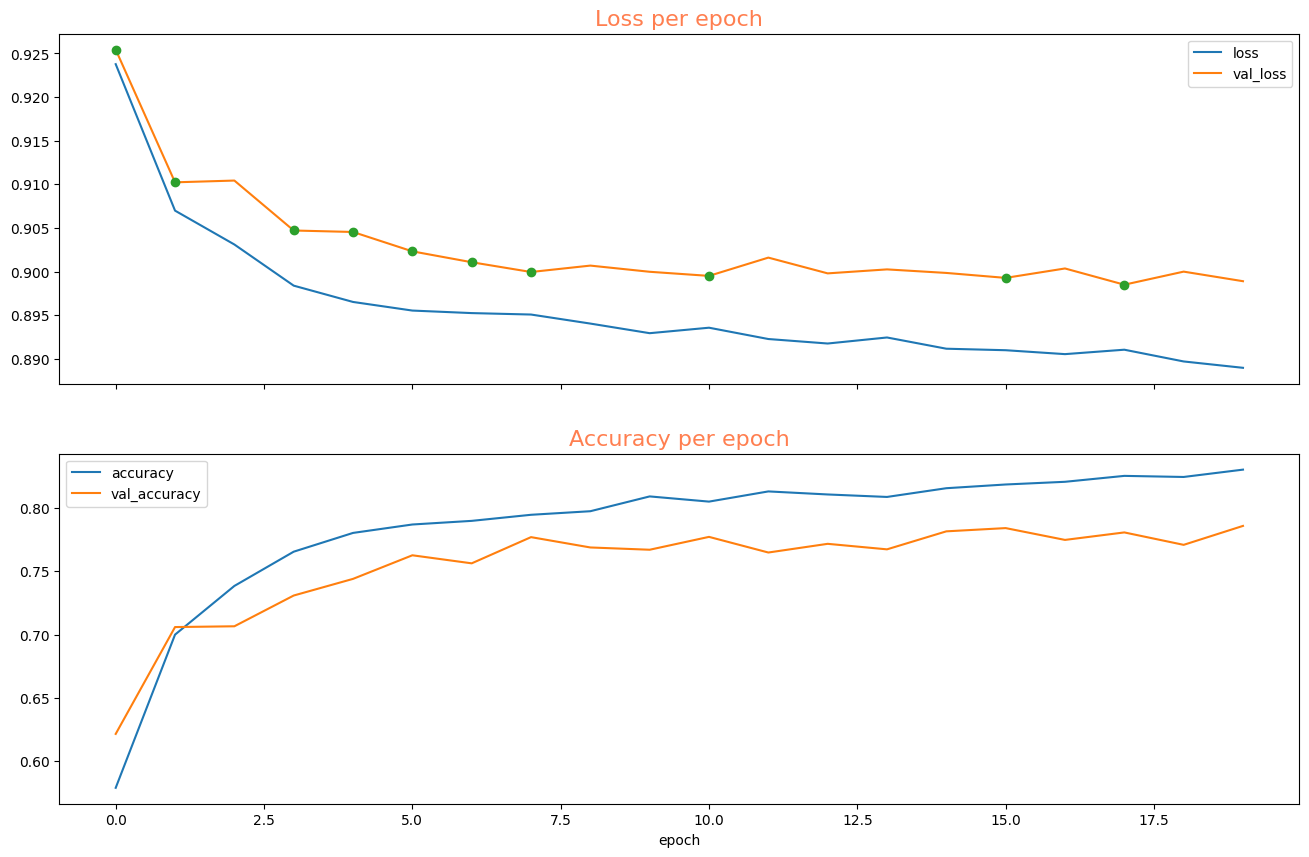

In [38]:
trainer.plot_training()

In [39]:
print("Training took {:.2f} seconds".format(trainer.total_duration))
print("Which is {:.2f} minutes".format(trainer.total_duration/60))

Training took 570.23 seconds
Which is 9.50 minutes


In [ ]:
print(trainer.__dict__)
memo["trainer"]=trainer.__dict__
memo["trainer.epoch_count"]=trainer.epoch_count
memo["trainer.best_epoch"]=trainer.best_epoch
memo["trainer.best_value"]=trainer.best_value
memo["trainer.total_duration"]=trainer.total_duration

In [41]:
#save the memo and the parameters of the model
memo.to_csv(Folder_out+"/memo.csv")

# Testing


In [ ]:
Folder_out

In [43]:
#load the last model saved 
model=load_model(Folder_out)

In [44]:
def cut_full_slice(matrix,label, window_size):

    margin=int(0.1*window_size)
    stride=window_size-2*margin

    size=len(matrix)//stride-1
    nb_input=matrix.shape[1]

    X= np.empty([size,window_size,nb_input])
    Y= np.empty([size,window_size],dtype=int)

    for i in range(size):
        t=i*stride
        X[i,:,:]=matrix[t:t+window_size ,:]
        Y[i]=label[t:t+window_size]

    return X, Y



def stick(Y):

    window_size=Y.shape[1]
    margin=int(0.1*window_size)

    res=[]
    res.append(Y[0,:window_size-margin])

    for i in range(1,len(Y)):
        res.append(Y[i,margin:-margin])

    return np.concatenate(res,axis=0)



## PLot / Comparaison

In [45]:
def get_all(turtle_names, matrices, labels, window_size):

    all_pred={}
    all_true={}

    for i,name in enumerate(turtle_names):
        matrix=matrices[name]
        label=labels[name]
        print(name,matrix.shape,label.shape)

        X_cut,Y_cut=cut_full_slice(matrix, label, window_size)
        Y_stick=stick(Y_cut)
        all_true[name]=Y_stick

        Y_cut_pred_proba=model.predict([X_cut])

        Y_cut_pred=np.argmax(Y_cut_pred_proba,axis=2)

        Y_stick_pred=stick(Y_cut_pred)
        all_pred[name]=Y_stick_pred

    return all_pred,all_true

In [46]:
all_pred,all_true=get_all(NAMES_ALL, Matrices, Labels, WINDOW_SIZE)

CC-09-80_08-03-2023_1 (531000, 7) (531000,)
26/26 [==============================] - 2s 41ms/step
CC-09-80_08-03-2023_2 (420299, 7) (420299,)
21/21 [==============================] - 1s 35ms/step
CC-09-72_02-11-2022_1 (685601, 7) (685601,)
34/34 [==============================] - 1s 34ms/step
CC-09-80_16-05-2023_1 (480267, 7) (480267,)
24/24 [==============================] - 1s 35ms/step
CC-09-80_16-05-2023_2 (232536, 7) (232536,)
12/12 [==============================] - 0s 35ms/step
CC-09-72_01-02-2023_1 (615327, 7) (615327,)
30/30 [==============================] - 1s 34ms/step
CC-09-72_01-02-2023_2 (663280, 7) (663280,)
33/33 [==============================] - 1s 35ms/step
CC-09-80_28-03-2023_1 (515456, 7) (515456,)
26/26 [==============================] - 1s 33ms/step
CC-09-80_28-03-2023_2 (429822, 7) (429822,)
21/21 [==============================] - 1s 37ms/step
CC-09-80_01-02-2023_1 (454996, 7) (454996,)
23/23 [==============================] - 1s 34ms/step


In [47]:
def plot_categorical_vector(ax,vector,cat_selected,cat_names,markersize=2,color=None,label=None):

    for cat in cat_selected:
        ax.set_label("toto")
        here=(vector==cat)
        x_here=np.arange(len(vector))[here]
        y_here=cat*np.ones(len(vector))[here]
        line,=ax.plot(x_here, y_here,'o',markersize=markersize,color=color)


    line.set_label(label)

    ax.set_yticks(range(len(cat_selected)))
    ax.tick_params(colors='coral')
    labels=[]
    for cat in cat_selected:
        labels.append(str(cat)+":"+cat_names[cat])

    ax.set_yticklabels(labels)

In [48]:
def plot_compa_Y(ax,y,y_pred):

    nb_output=len(CLASSES)
    class_names=[CLASS.name for CLASS in CLASSES]


    plot_categorical_vector(ax,y,range(nb_output),class_names,markersize=3,color="blue",label="Y")
    plot_categorical_vector(ax,y_pred,range(nb_output),class_names,markersize=1,color="red",label="Y_pred")

    ax.legend()


In [49]:
def plot_compa(turtle_names,title,deb=0,fin=-1):
    #deb=0
    #fin=-1
    nb=len(turtle_names)
    fig,axs=plt.subplots(nb,1,figsize=(12,2*nb),sharex=False)
    if nb==1:axs=[axs]

    for i,name in enumerate(turtle_names):
        plot_compa_Y(axs[i],all_true[name][deb:fin],all_pred[name][deb:fin])
        axs[i].set_title(name, color="coral", fontsize=16)

    fig.tight_layout()

    fig.savefig(Folder_out+"/"+title+".png")

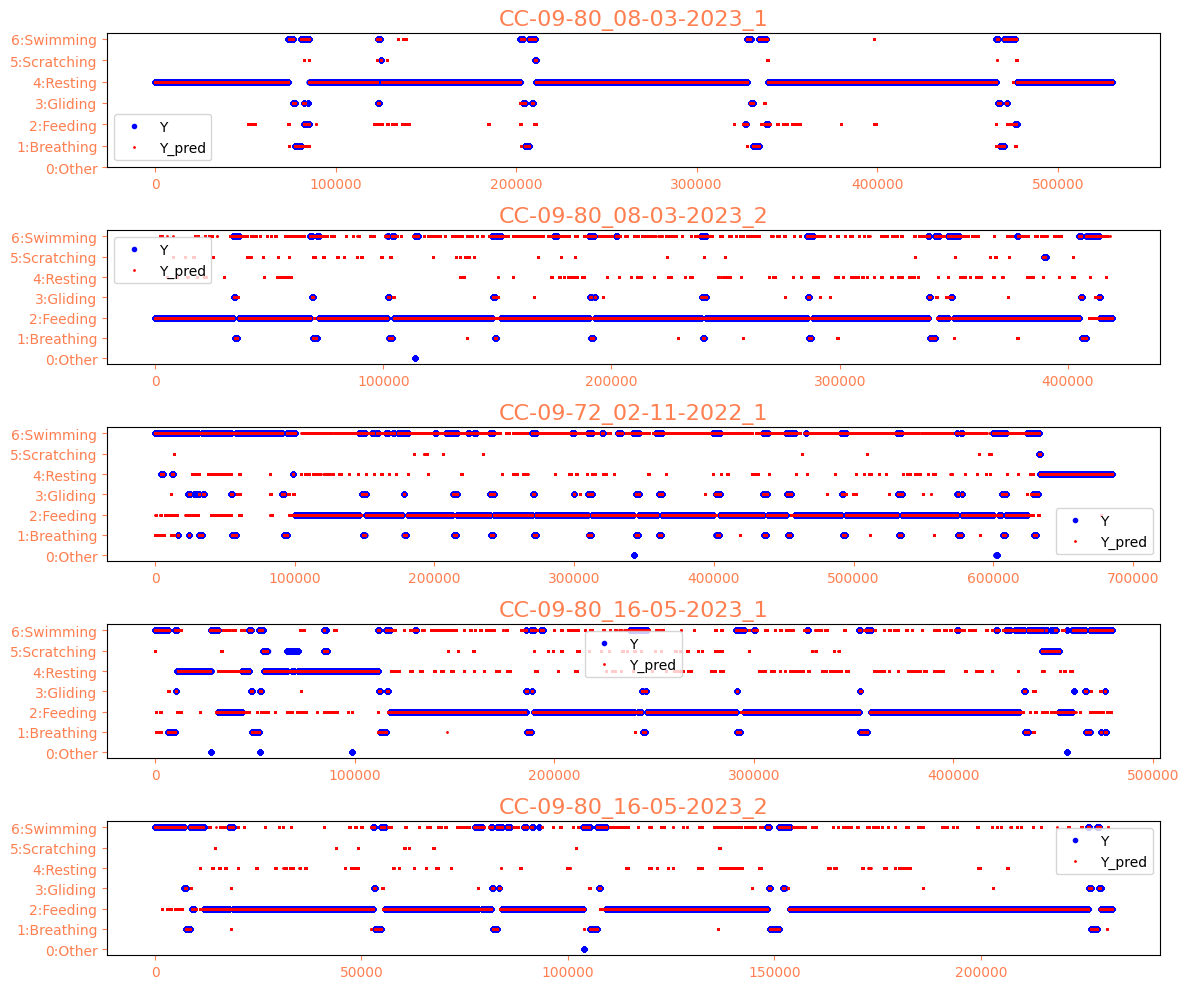

In [50]:
plot_compa(NAMES_TRAIN,"compa on train")

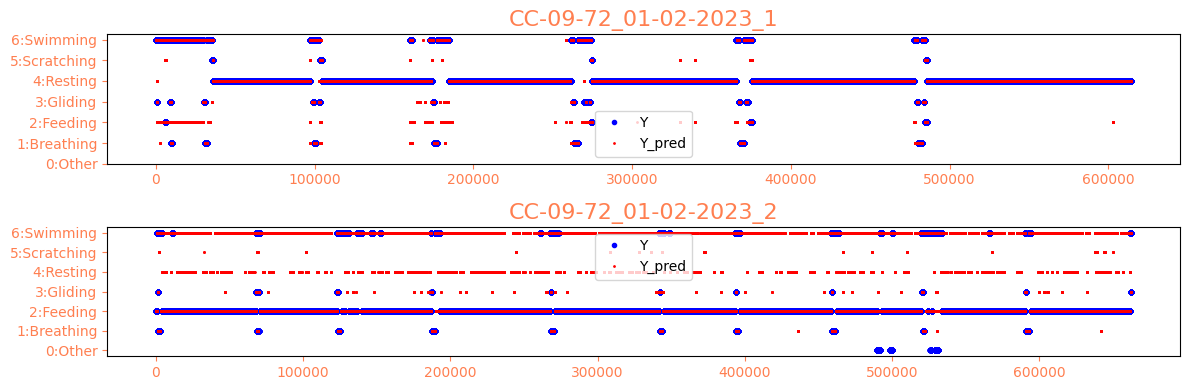

In [51]:
plot_compa(NAMES_VAL,"compa on val")

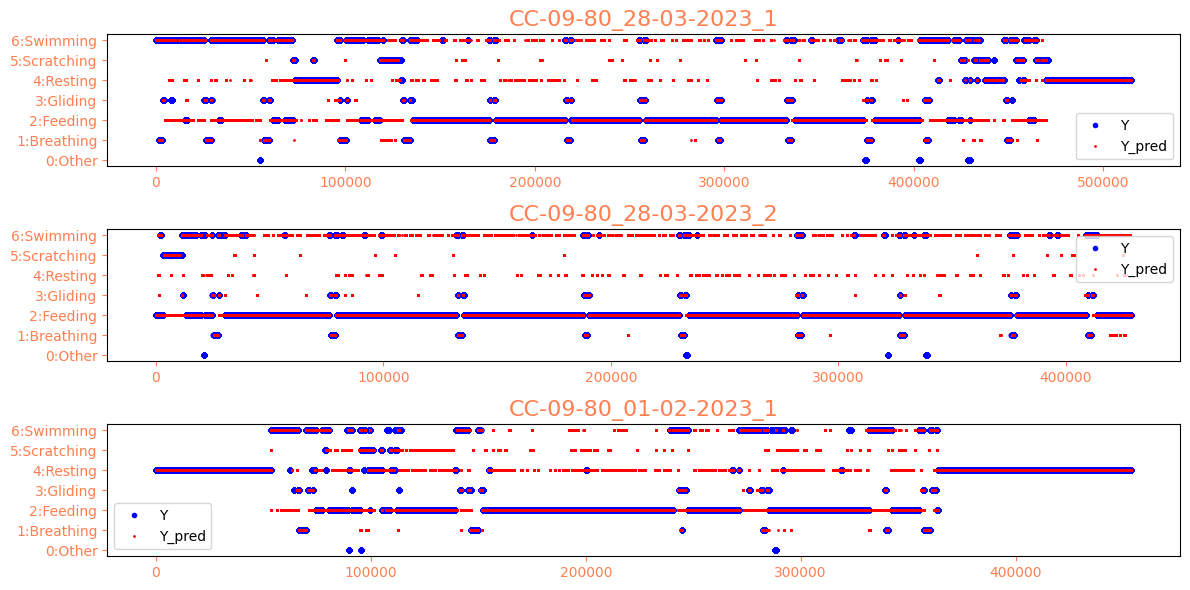

In [52]:
plot_compa(NAMES_TEST,"compa on test")

## Confusion Matrix


In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap="jet",
                          precision=2,
                         ):


    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    print("Confusion matrix, without normalization:")
    print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()
    fig.savefig(Folder_out+"/"+title)



Confusion matrix, without normalization:
[[     0     21   2726      0      0    182    288]
 [     0  48526      5    179      0    105    506]
 [     0    553 751575    377  52542   8939  32878]
 [     0   1701   5376  17068    733     53   2287]
 [     0      0   6830     39 224095    249    353]
 [     0   1272  20518     45   1131  19305    533]
 [     0    983  71649   3308   2296   1412 116722]]
Normalized confusion matrix
[[0.00e+00 6.53e-03 8.47e-01 0.00e+00 0.00e+00 5.66e-02 8.95e-02]
 [0.00e+00 9.84e-01 1.01e-04 3.63e-03 0.00e+00 2.13e-03 1.03e-02]
 [0.00e+00 6.53e-04 8.87e-01 4.45e-04 6.20e-02 1.06e-02 3.88e-02]
 [0.00e+00 6.25e-02 1.98e-01 6.27e-01 2.69e-02 1.95e-03 8.40e-02]
 [0.00e+00 0.00e+00 2.95e-02 1.68e-04 9.68e-01 1.08e-03 1.52e-03]
 [0.00e+00 2.97e-02 4.79e-01 1.05e-03 2.64e-02 4.51e-01 1.25e-02]
 [0.00e+00 5.01e-03 3.65e-01 1.68e-02 1.17e-02 7.19e-03 5.94e-01]]


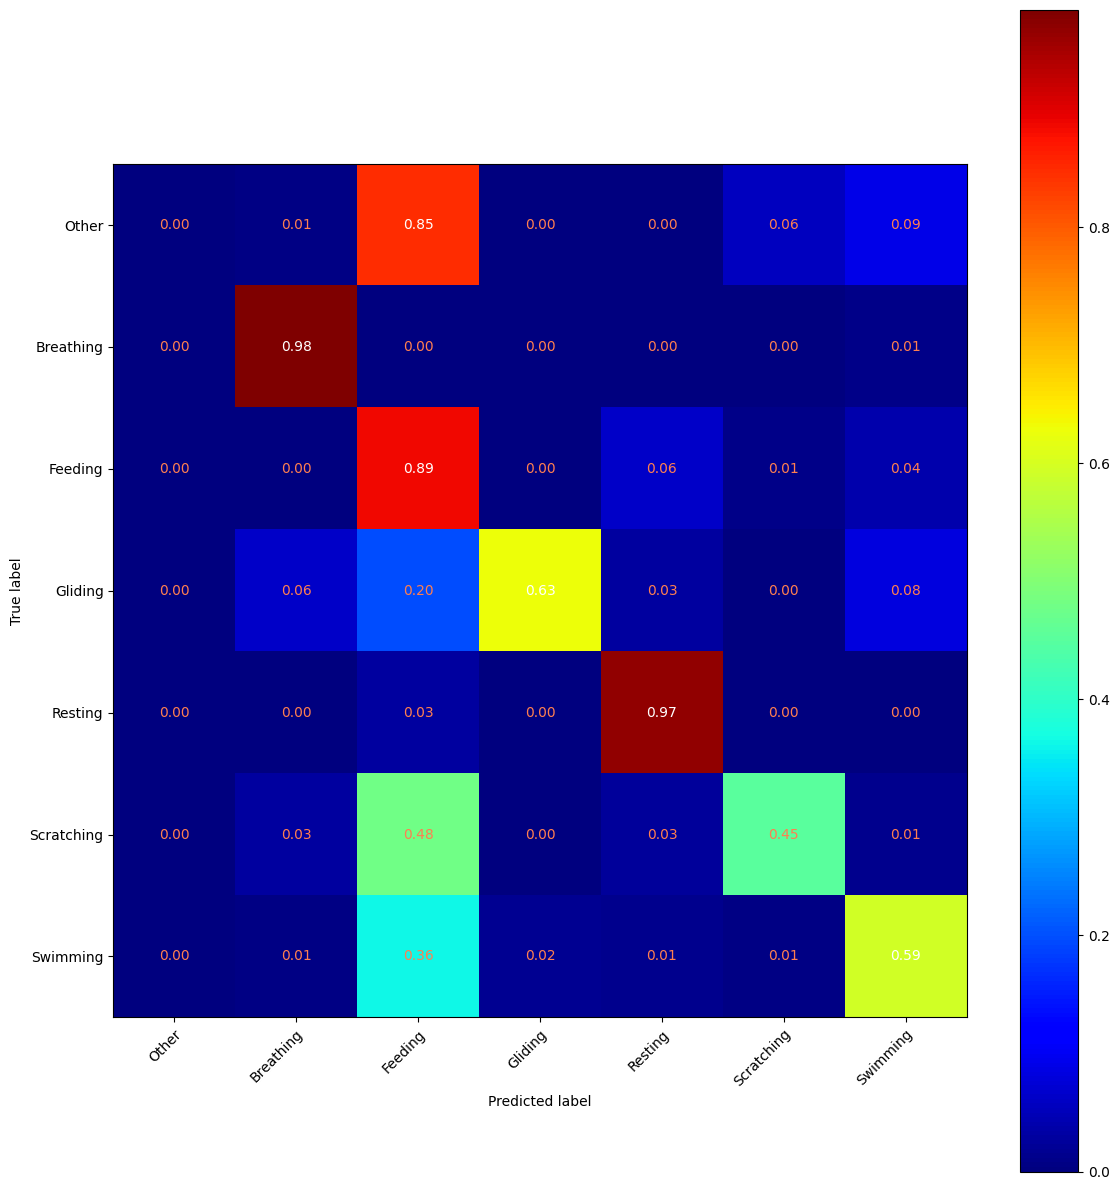

In [54]:
#calculate the confusion matrix only on the testing dataset
whole_true=[]
whole_pred=[]
for name in NAMES_TEST:
    whole_true.append(all_true[name])
    whole_pred.append(all_pred[name])

whole_true=np.concatenate(whole_true)
whole_pred=np.concatenate(whole_pred)
class_names=[CLASS.name for CLASS in CLASSES]

plot_confusion_matrix(whole_true,whole_pred, np.array(class_names),True,"whole validation")


In [55]:
#To calculate Precisionm Recall, Specificity and F1-score

cm = confusion_matrix(whole_true, whole_pred)

print(cm)
TP=np.diag(cm)
FP=np.sum(cm,axis=1)-TP
FN=np.sum(cm,axis=0)-TP
TN=np.ones(len(class_names))*np.sum(cm)-TP-FP-FN

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall=TP/(TP+FN)
Precision =TP/(TP+FP)
Specificity =TN/(TN+FP)
F1_score=2*(Recall*Precision)/ (Recall+Precision)


[[     0     21   2726      0      0    182    288]
 [     0  48526      5    179      0    105    506]
 [     0    553 751575    377  52542   8939  32878]
 [     0   1701   5376  17068    733     53   2287]
 [     0      0   6830     39 224095    249    353]
 [     0   1272  20518     45   1131  19305    533]
 [     0    983  71649   3308   2296   1412 116722]]


C:\Users\loren\AppData\Local\Temp\ipykernel_4980\4158152279.py:12: RuntimeWarning: invalid value encountered in divide
  Recall=TP/(TP+FN)


In [56]:
df = pd.DataFrame({'Accuracy': Accuracy, 'Recall': Recall, 'Precision': Precision, 'Specificity': Specificity, 'F1_score': F1_score},
                      index = class_names)
df

,Accuracy,Recall,Precision,Specificity,F1_score
Other,0.997698,NaN,0.000000,0.997698,NaN
Breathing,0.996189,0.914619,0.983881,0.999409,0.947986
Feeding,0.855160,0.875269,0.887480,0.823107,0.881332
Gliding,0.989911,0.812143,0.627085,0.992625,0.707717
Resting,0.954076,0.798068,0.967737,0.993309,0.874751
Scratching,0.975354,0.638287,0.451009,0.982811,0.528549
Swimming,0.916634,0.760072,0.594398,0.935964,0.667103


In [57]:
Global_accuracy=(np.sum(TP)+np.sum(TN))/(np.sum(TP)+np.sum(TN)+np.sum(FP)+np.sum(FN))
print("Global Accuracy :", Global_accuracy)

Global Accuracy : 0.9550031079014305


In [58]:
F1_score=np.mean(df['F1_score'][~np.isnan(df['F1_score'])])
print("F1-score :", F1_score)

F1-score : 0.7679063846827127
